In [1]:
import pandas as pd
import numpy as np
from Dora import Dora
import mypy
from matplotlib import pyplot as plt

dataset = pd.read_csv('weather_data_top100.csv').drop('date', axis=1)

Перший погляд на датасет:

In [2]:
dataset.head()    

,tavg,tmin,tmax,prcp,snow,wspd,pres,country,city
0,-3.0,-8.0,1.0,NaN,NaN,NaN,NaN,Afghanistan,Kabul
1,-6.2,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan,Kabul
2,-7.7,-14.0,2.0,NaN,NaN,NaN,NaN,Afghanistan,Kabul
3,-8.4,-15.0,-2.0,NaN,NaN,NaN,NaN,Afghanistan,Kabul
4,-7.8,-14.0,NaN,NaN,NaN,NaN,NaN,Afghanistan,Kabul


Детальніше про кожну колонку

In [3]:
dataset.describe(include='all')

,tavg,tmin,tmax,prcp,snow,wspd,pres,country,city
count,799501.000000,716627.000000,763377.000000,465075.000000,40081.000000,535406.000000,322548.000000,851512,851512
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86,86
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,China,Beijing
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16681,16681
mean,18.680032,13.502184,23.347088,2.874872,5.813453,12.072765,1014.237086,NaN,NaN
std,9.910905,9.429174,10.695030,13.386526,13.612276,6.777007,8.092901,NaN,NaN
min,-38.400000,-39.500000,-31.300000,0.000000,0.000000,0.000000,959.200000,NaN,NaN
25%,12.600000,7.000000,16.800000,0.000000,0.000000,7.600000,1009.700000,NaN,NaN
50%,19.900000,14.000000,24.800000,0.000000,0.000000,10.700000,1013.900000,NaN,NaN
75%,26.700000,21.000000,31.500000,1.200000,6.000000,14.900000,1019.000000,NaN,NaN


Типи даних у колонках:

In [4]:
dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851512 entries, 0 to 851511
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   tavg     799501 non-null  float64
 1   tmin     716627 non-null  float64
 2   tmax     763377 non-null  float64
 3   prcp     465075 non-null  float64
 4   snow     40081 non-null   float64
 5   wspd     535406 non-null  float64
 6   pres     322548 non-null  float64
 7   country  851512 non-null  object 
 8   city     851512 non-null  object 
dtypes: float64(7), object(2)
memory usage: 138.2 MB


In [5]:
float_types = ["float32", "float64"]
for it in float_types:
    print(np.finfo(it))

Machine parameters for float32
---------------------------------------------------------------
precision =   6   resolution = 1.0000000e-06
machep =    -23   eps =        1.1920929e-07
negep =     -24   epsneg =     5.9604645e-08
minexp =   -126   tiny =       1.1754944e-38
maxexp =    128   max =        3.4028235e+38
nexp =        8   min =        -max
smallest_normal = 1.1754944e-38   smallest_subnormal = 1.4012985e-45
---------------------------------------------------------------

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
smallest_normal = 2.2250738585072014e-308   smallest_subnormal = 4.9406564584124654e-324
------------------

Висновки: 

1. Колонкам **tavg**, **tmin**, **tmax**, **prcp**, **snow**, **wspd**, **pres** не потрібна настільки велика точність та доступний діапазон значень, які пропонує float64. Це логічно, позаяк різні стани погоди утворюються за різних значень згаданих показників, і для зміни цього стану потрібна суттєва зміна показників, так як ці величини змінюються неперервним чином. Маленькі ж зрушення цих показників несуттєво впливають на загальний стан погоди.

2. Пропонується виставити для колонок **tavg**, **tmin**, **tmax**, **prcp**, **snow**, **wspd**, **pres** тип даних float32 (мінімально можливий, який надає метод **to_numeric()**).

3. Так як датасет містить 851512 спостереження показників погоди у 86 різних містах світу, то на одне місто в середньому припадає $\approx$ 10.000 спостережень, кожне з яких супроводжується відповідним йому значенням **country**, то раціональним буде ввести категорійне кодування для колонок **country** та **city**


Імплементація: спочатку збережемо інформацію про використовуваний обсяг пам'яті із типом float64

In [6]:
def calc_memory_usage(dataset, type_of_float):
    selected_columns = dataset.select_dtypes(include=['float'])
    total_usage_bytes = selected_columns.memory_usage(deep=True, index=False).sum()
    total_usage_mb = total_usage_bytes / 1e6
    memory_before_transformation = {type_of_float: [total_usage_mb]}
    print(f"Total memory usage for {type_of_float} columns: " + str(round(total_usage_mb, 3)) + " MB")
    return memory_before_transformation
memory_before_transformation = calc_memory_usage(dataset, 'float64')

Total memory usage for float64 columns: 47.685 MB


47 з копійками мегабайт, і це ще й з купою NaN'ів всередині...

In [7]:
dataset_float = dataset.select_dtypes(include=['float'])
converted_float = dataset_float.apply(pd.to_numeric, downcast='float')
optimized_dataset = dataset.copy()
optimized_dataset[converted_float.columns] = converted_float
memory_before_after_transformation = memory_before_transformation | calc_memory_usage(optimized_dataset, 'float32') # об'єдную два словники

Total memory usage for float32 columns: 23.842 MB


Обсяг використовуваної пам'яті зменшився вдвічі(!)

Тепер займемось колонками **country**, **city**: 

In [8]:
dataset_object = dataset.select_dtypes(include=['object'])
dataset_object.head()

,country,city
0,Afghanistan,Kabul
1,Afghanistan,Kabul
2,Afghanistan,Kabul
3,Afghanistan,Kabul
4,Afghanistan,Kabul


In [9]:
dataset_object.info(memory_usage='deep')
memory_before_after_transformation = memory_before_after_transformation | {'object': [92.7]}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851512 entries, 0 to 851511
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   country  851512 non-null  object
 1   city     851512 non-null  object
dtypes: object(2)
memory usage: 92.7 MB


Всього дві колонки, а займають 92.7 МБ. Сконвертуємо їх в тип **category**:

In [10]:
converted_object = dataset_object.astype('category')
converted_object.head()

,country,city
0,Afghanistan,Kabul
1,Afghanistan,Kabul
2,Afghanistan,Kabul
3,Afghanistan,Kabul
4,Afghanistan,Kabul


Візуально вигляд цих колонок не змінився, але під капотом... 

In [47]:
converted_object.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851512 entries, 0 to 851511
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   country  851512 non-null  category
 1   city     851512 non-null  category
dtypes: category(2)
memory usage: 1.6 MB


Вийшло зменшити їх обсяг пам'яті майже в 58 разів! Запишемо це в словник:

In [12]:
memory_before_after_transformation = memory_before_after_transformation | {'category': [1.6]}
memory_before_after_transformation

{'float64': [np.float64(47.684672)],
 'float32': [np.float64(23.842336)],
 'object': [92.7],
 'category': [1.6]}

In [13]:
optimized_dataset[converted_object.columns] = converted_object

Тепер заповнимо пропущені значення за допомогою бібліотеки Dora:

In [14]:
optimized_dataset['dummy_col'] = np.array([1 for j in range(optimized_dataset.shape[0])])
dora_dataset = Dora(output='dummy_col', data=optimized_dataset.select_dtypes(['float', 'int']))
dora_dataset.data

,tavg,tmin,tmax,prcp,snow,wspd,pres,dummy_col
0,-3.000000,-8.0,1.000000,NaN,NaN,NaN,NaN,1
1,-6.200000,NaN,NaN,NaN,NaN,NaN,NaN,1
2,-7.700000,-14.0,2.000000,NaN,NaN,NaN,NaN,1
3,-8.400000,-15.0,-2.000000,NaN,NaN,NaN,NaN,1
4,-7.800000,-14.0,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...
851507,19.299999,15.1,23.900000,NaN,NaN,12.0,NaN,1
851508,20.200001,15.2,25.200001,NaN,NaN,14.2,NaN,1
851509,20.200001,15.4,25.400000,NaN,NaN,16.4,NaN,1
851510,20.799999,13.9,27.299999,NaN,NaN,15.3,NaN,1


In [15]:
dora_dataset.impute_missing_values()
dora_dataset.data

,tavg,tmin,tmax,prcp,snow,wspd,pres,dummy_col
0,-3.000000,-8.000000,1.000000,2.874871,5.813453,12.072765,1014.237122,1
1,-6.200000,13.502185,23.347088,2.874871,5.813453,12.072765,1014.237122,1
2,-7.700000,-14.000000,2.000000,2.874871,5.813453,12.072765,1014.237122,1
3,-8.400000,-15.000000,-2.000000,2.874871,5.813453,12.072765,1014.237122,1
4,-7.800000,-14.000000,23.347088,2.874871,5.813453,12.072765,1014.237122,1
...,...,...,...,...,...,...,...,...
851507,19.299999,15.100000,23.900000,2.874871,5.813453,12.000000,1014.237122,1
851508,20.200001,15.200000,25.200001,2.874871,5.813453,14.200000,1014.237122,1
851509,20.200001,15.400000,25.400000,2.874871,5.813453,16.400000,1014.237122,1
851510,20.799999,13.900000,27.299999,2.874871,5.813453,15.300000,1014.237122,1


In [16]:
dora_dataset.data.describe(include='all')

,tavg,tmin,tmax,prcp,snow,wspd,pres,dummy_col
count,851512.000000,851512.000000,851512.000000,851512.000000,851512.000000,851512.000000,851512.000000,851512.0
mean,18.680033,13.502184,23.347088,2.874871,5.813453,12.072766,1014.237183,1.0
std,9.603453,8.650173,10.126424,9.893132,2.953245,5.373831,4.980875,0.0
min,-38.400002,-39.500000,-31.299999,0.000000,0.000000,0.000000,959.200012,1.0
25%,13.100000,8.500000,17.900000,0.000000,5.813453,9.400000,1014.237122,1.0
50%,19.000000,13.502185,23.347088,2.874871,5.813453,12.072765,1014.237122,1.0
75%,26.299999,19.400000,31.000000,2.874871,5.813453,12.200000,1014.237122,1.0
max,43.299999,39.000000,62.000000,778.000000,310.000000,88.199997,1057.699951,1.0


Тепер коли всі комірки заповнені, зливаємо разом очищену частину та дві категорійні колонки

In [17]:
optimized_dataset[optimized_dataset.select_dtypes('float').columns] = dora_dataset.data.iloc[:, :-1]
optimized_dataset = optimized_dataset.drop('dummy_col', axis=1)
optimized_dataset.head(10)

,tavg,tmin,tmax,prcp,snow,wspd,pres,country,city
0,-3.0,-8.000000,1.000000,2.874871,5.813453,12.072765,1014.237122,Afghanistan,Kabul
1,-6.2,13.502185,23.347088,2.874871,5.813453,12.072765,1014.237122,Afghanistan,Kabul
2,-7.7,-14.000000,2.000000,2.874871,5.813453,12.072765,1014.237122,Afghanistan,Kabul
3,-8.4,-15.000000,-2.000000,2.874871,5.813453,12.072765,1014.237122,Afghanistan,Kabul
4,-7.8,-14.000000,23.347088,2.874871,5.813453,12.072765,1014.237122,Afghanistan,Kabul
5,-8.2,-13.000000,2.000000,2.874871,5.813453,12.072765,1014.237122,Afghanistan,Kabul
6,-5.4,-13.000000,-1.000000,2.874871,5.813453,12.072765,1014.237122,Afghanistan,Kabul
7,-1.7,-7.000000,2.000000,2.874871,5.813453,12.072765,1014.237122,Afghanistan,Kabul
8,-3.1,13.502185,3.000000,2.874871,5.813453,12.072765,1014.237122,Afghanistan,Kabul
9,-3.8,13.502185,5.000000,2.874871,5.813453,12.072765,1014.237122,Afghanistan,Kabul


In [18]:
optimized_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851512 entries, 0 to 851511
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   tavg     851512 non-null  float32 
 1   tmin     851512 non-null  float32 
 2   tmax     851512 non-null  float32 
 3   prcp     851512 non-null  float32 
 4   snow     851512 non-null  float32 
 5   wspd     851512 non-null  float32 
 6   pres     851512 non-null  float32 
 7   country  851512 non-null  category
 8   city     851512 non-null  category
dtypes: category(2), float32(7)
memory usage: 24.4 MB


У підсумку, повністю готовий до подальшої роботи датасет займає 24.4 МБ у порівнянні із початково сирим датасетом у 138.2 МБ

Підготуємо візуалізації:

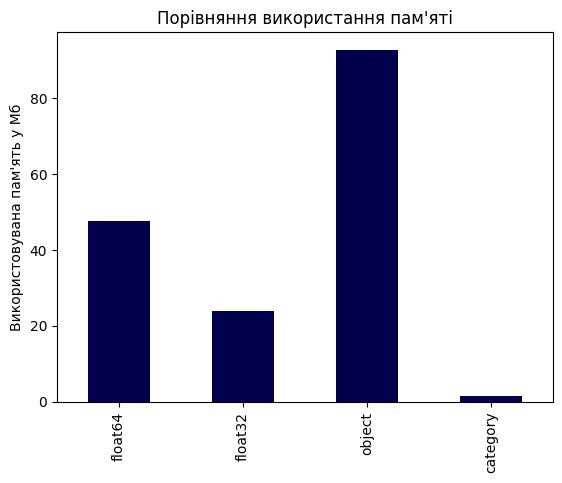

In [25]:
impact = pd.DataFrame(data=memory_before_after_transformation).T
impact.plot(kind='bar', legend=False, colormap='seismic', title='Порівняння використання пам\'яті', ylabel='Використовувана пам\'ять у Мб')
plt.show()

Відсотковий приріст якості використання пам'яті:

In [43]:
print(f'Для чисельних колонок: \n\tБуло: {round(impact.iloc[0].values[0],1)} МБ \t\tСтало: {round(impact.iloc[1].values[0],1)} МБ \t\tПриріст: {round(round(impact.iloc[0].values[0],3)/round(impact.iloc[1].values[0],3))*100}%\n\n')
print(f'Для категорійних колонок: \n\tБуло: {round(impact.iloc[2].values[0],3)} МБ \t\tСтало: {round(impact.iloc[3].values[0],3)} МБ \t\tПриріст: {round(round(impact.iloc[2].values[0],3)/round(impact.iloc[3].values[0],3))*100}%')

Для чисельних колонок: 
	Було: 47.7 МБ 		Стало: 23.8 МБ 		Приріст: 200%


Для категорійних колонок: 
	Було: 92.7 МБ 		Стало: 1.6 МБ 		Приріст: 5800%
